# Práctico 6 - Procesamiento Digital de Imágenes

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import canny

%matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

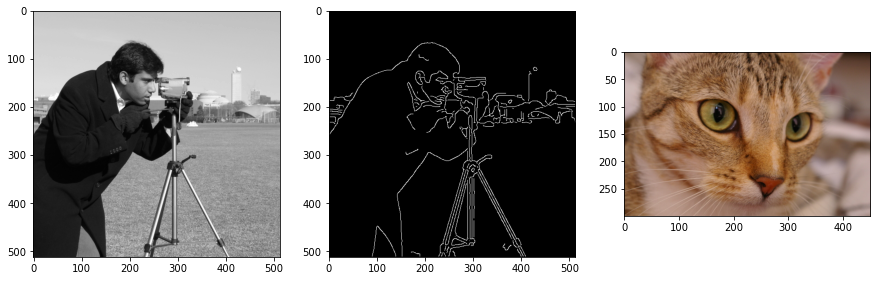

In [3]:
img_gray = imageio.imread('imageio:camera.png')/255
img_rgb = imageio.imread('imageio:chelsea.png')/255
# img_bin = canny(rgb2yiq(img_rgb)[:,:,0], sigma=2)
img_bin = canny(img_gray, sigma=2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_bin, 'gray')
axes[2].imshow(img_rgb)

# Operaciones morfológicas

Implementar funciones que devuelvan los siguientes structuring elements. Son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). Incluso pueden construirse aplicando un threshold a un kernel. Ej: se_box = kernel_box > 0

1. Box
2. Circle

Utilizando las funciones de ejemplo implementar las siguientes operaciones morfológicas, tanto para escala de grises como para RGB. Para RGB realizar la operación en base a los valores del canal Y:

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

Operaciones de suma/resta entre erosión y dilatación:

4. Borde externo (dilatacion - imagen)
5. Borde interno (imagen - erosion)
6. Gradiente (dilatación - erosión)

Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (opening)
8. Cierre (closing)
9. Top-hat
10. Bottom-hat

Operaciones concatenando cierre y apertura (nivel 3):

11. OC
12. CO

Funciones útiles a partir de operaciones morfológicas:

13. Suavizado. Puede calcularse como el promedio entre operaciones del mismo nivel. Ej: (dilatación + erosión)/2  o  (apertura + cierre)/2. Los parámetros de entrada deben ser la imagen, el structuring element y el nivel deseado.
14. Realce de contraste (agregar una "porción" de pasaaltos, donde el pasaaltos puede construirse a partir del smoothing). Los parámetros de entrada deben ser los del smoothing utilizado y el factor que mutiplica al pasaaltos.

NOTA: Puede ser conveniente clampear el realce de contraste a [0,1], ya que al agregar pasaaltos la imagen puede salirse del rango. En este caso, matplotlib escala la imagen automáticamente y puede parecer que la luminosidad cambió. 

Aplicaciones útiles:

1. Extracción de texto
2. Eliminación de texto
3. Segmentación del iris del ojo

In [4]:
#img = imagen, se = structuring element, fcn = operación a realizar. ej: np.max()
def _morph_op(img, se, fcn):
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def im_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

In [5]:
se = np.ones((7,7), dtype=bool)

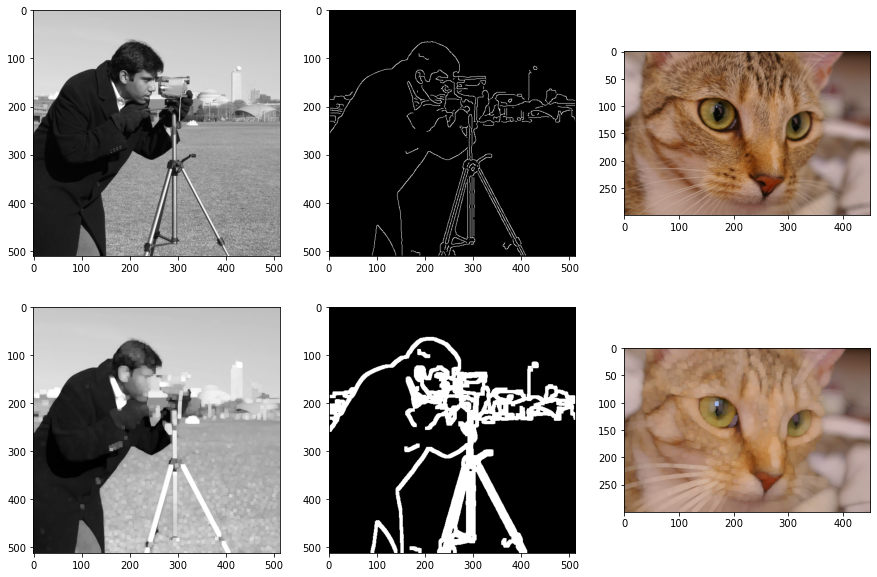

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(im_dilate(img_gray, se), 'gray')
axes[1,1].imshow(im_dilate(img_bin, se), 'gray')
axes[1,2].imshow(im_dilate(img_rgb, se))

In [7]:
#BOX 
# Box (cuadrado) -> params: N
def box_SE(N):
    kernel = np.ones((N,N))
    se_box = kernel > 0
    return(se_box)

In [8]:
print(box_SE(3))

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [9]:
def circle_SE(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    se_circle = kernel > 0
    return se_circle

In [10]:
se_circle = circle_SE(1)

# Operaciones básicas (nivel 1):

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

In [11]:
#Dilatación
def img_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

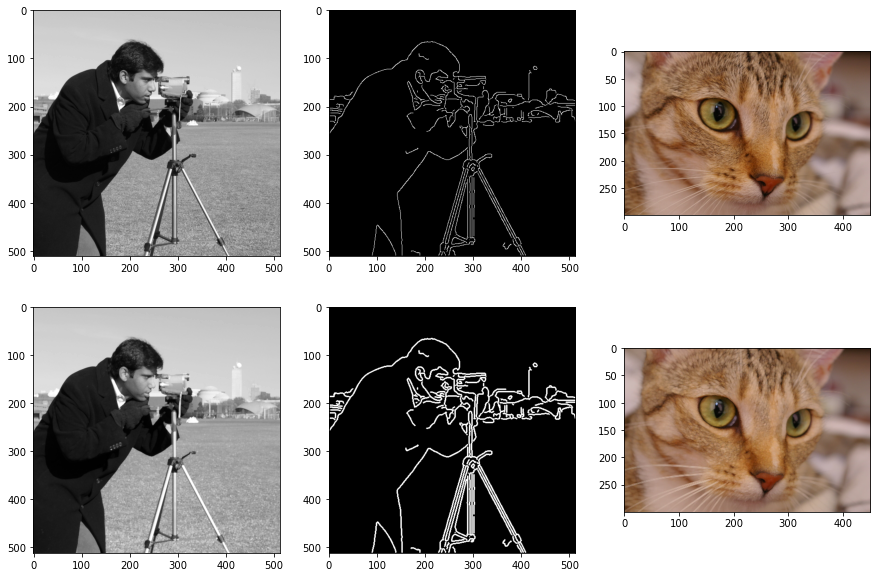

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_dilate(img_gray, se_circle), 'gray')
axes[1,1].imshow(img_dilate(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_dilate(img_rgb, se_circle))

In [13]:
#Erosion
def img_erosion(img, se):
    '''Morphological erosion for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)

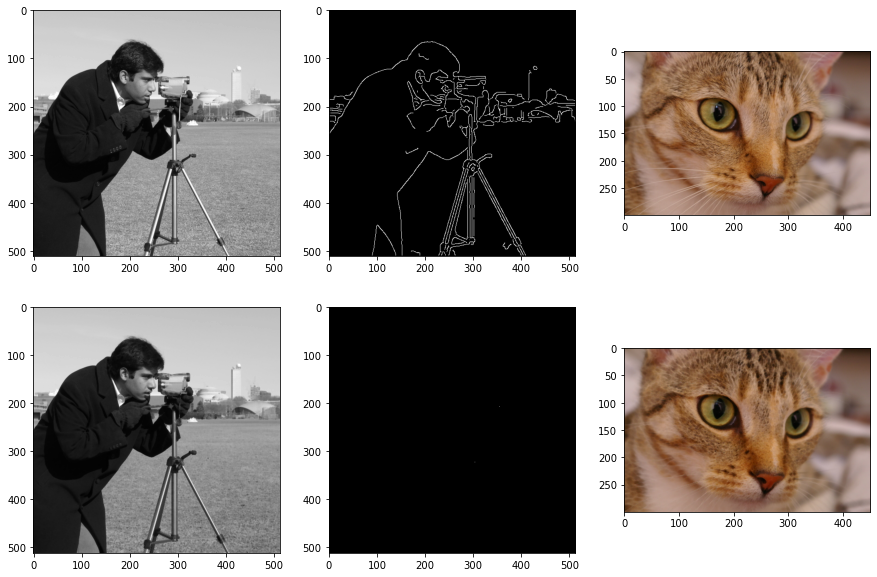

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_erosion(img_gray, se_circle), 'gray')
axes[1,1].imshow(img_erosion(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_erosion(img_rgb, se_circle))

In [15]:
def arg_median(array):
    array = np.argsort(array)
    indice = (len(array)+1)/2
    indice_array = array[int(indice)]
    return indice_array

def img_median(img, se):
    '''Morphological erosion for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.median)
    else:
        return _morph_color(img, se, arg_median)

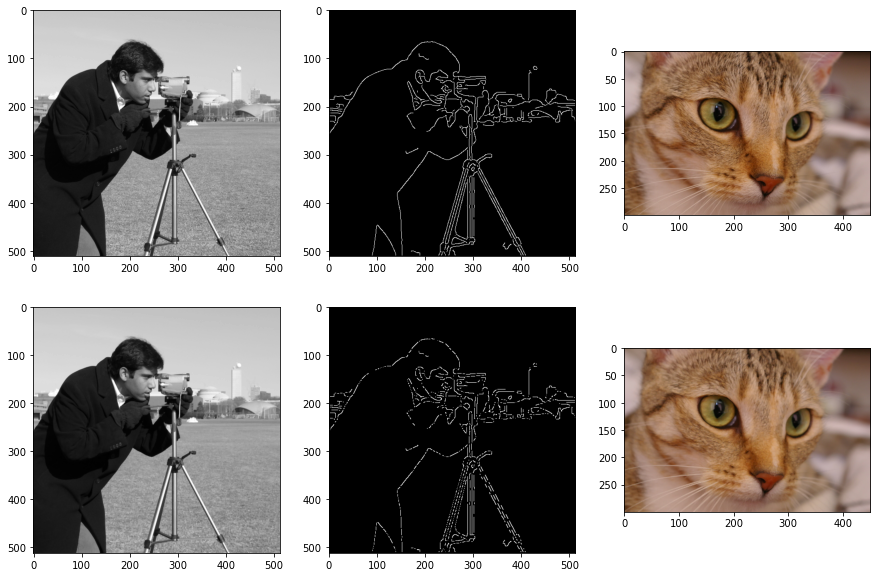

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_median(img_gray, se_circle), 'gray')
axes[1,1].imshow(img_median(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_median(img_rgb, se_circle))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


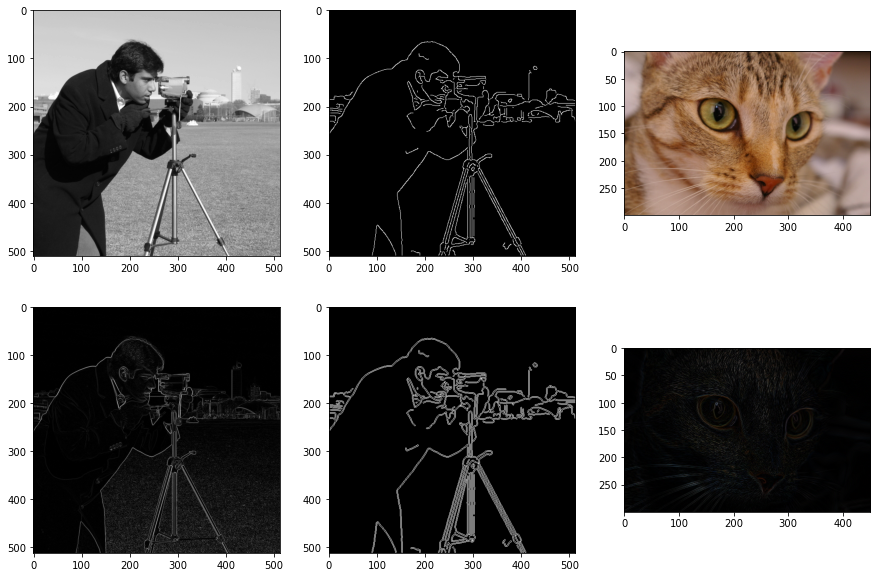

In [20]:
def borde_externo(img, se):
    img_borde_externo = img_dilate(img, se) - img
    return img_borde_externo

#4. Borde externo (dilatacion - imagen)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(borde_externo(img_gray, se_circle) , 'gray')
axes[1,1].imshow(borde_externo(img_bin, se_circle) , 'gray')
axes[1,2].imshow(borde_externo(img_rgb, se_circle))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


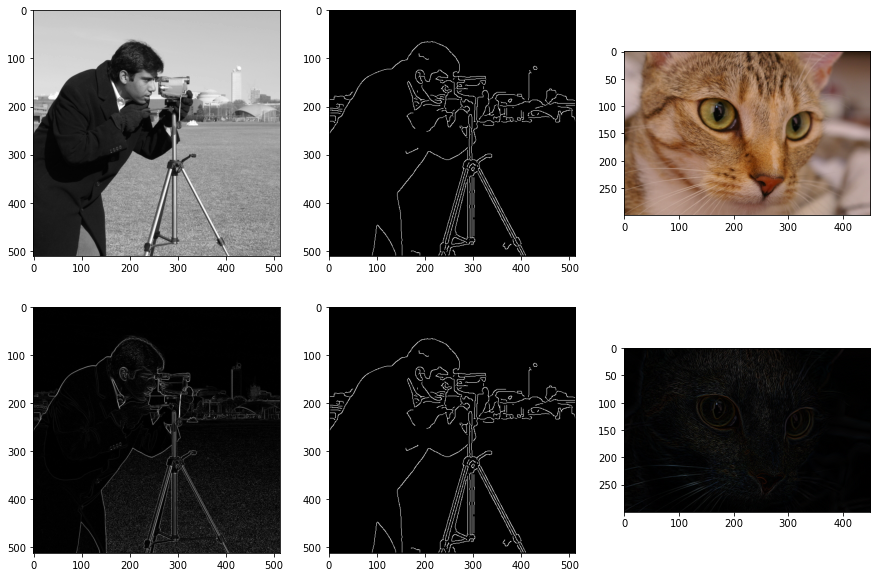

In [21]:
def borde_interno(img, se):
    img_borde_interno = img - img_erosion(img, se)
    return img_borde_interno

#5. Borde interno (imagen - erosion)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(borde_interno(img_gray, se_circle), 'gray')
axes[1,1].imshow(borde_interno(img_bin, se_circle), 'gray')
axes[1,2].imshow(borde_interno(img_rgb, se_circle))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


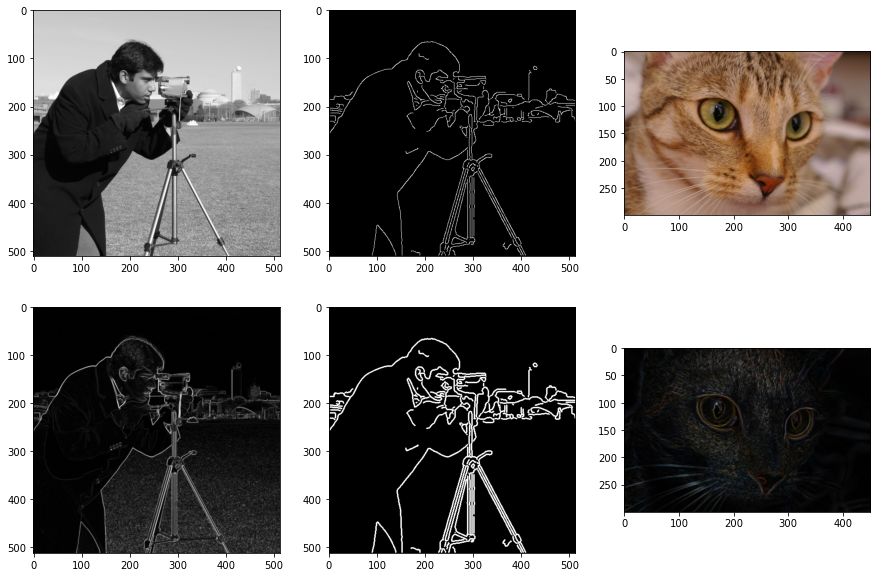

In [22]:
def gradiente(img, se):
    img_gradiente = img_dilate(img, se) - img_erosion(img, se)
    return img_gradiente

#6. Gradiente (dilatación - erosión)

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(gradiente(img_gray, se_circle) , 'gray')
axes[1,1].imshow(gradiente(img_bin, se_circle), 'gray')
axes[1,2].imshow(gradiente(img_rgb, se_circle))

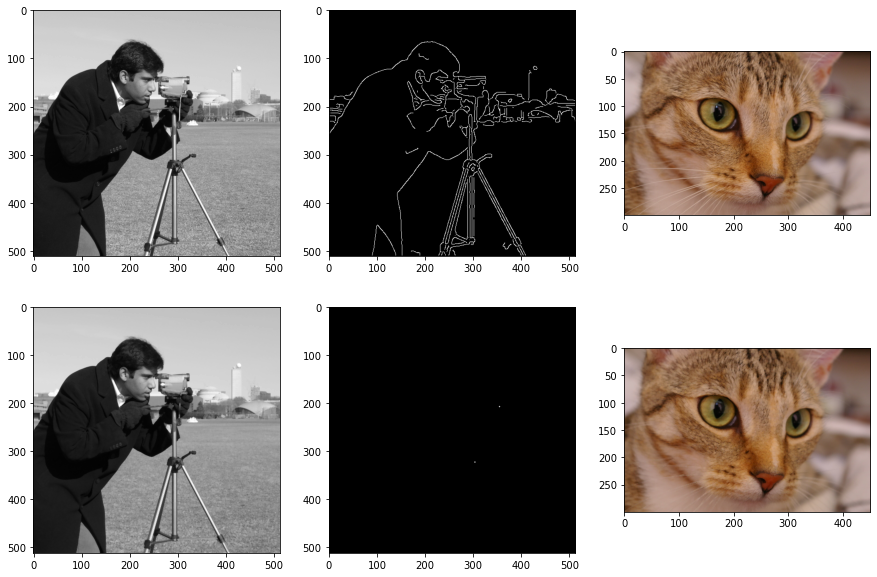

In [24]:
#Apertura (opening)

def img_opening(img, se):
    img_opening = img_dilate(img_erosion(img, se), se)
    return img_opening

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_opening(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_opening(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_opening(img_rgb, se_circle))


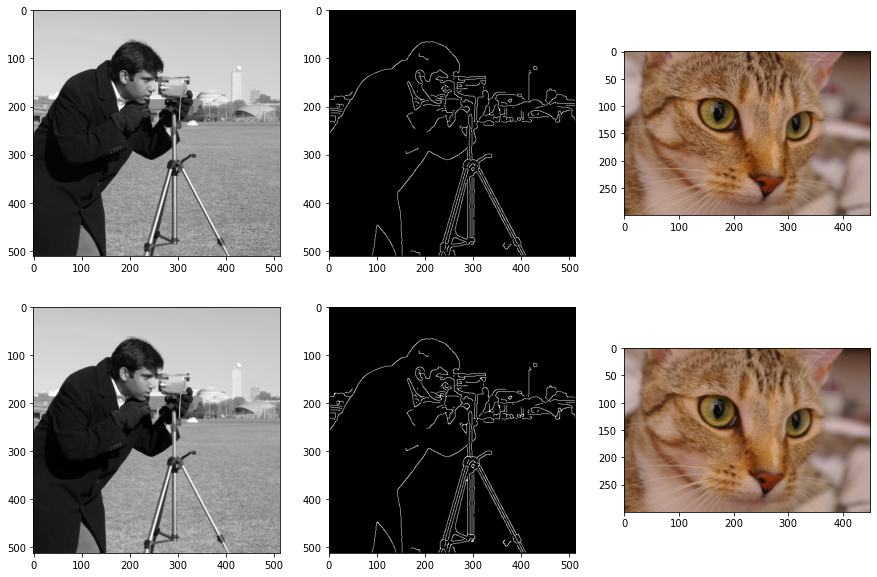

In [25]:
#Cierre (closing)

def img_closing(img, se):
    img_closing = img_erosion(img_dilate(img, se), se)
    return img_closing

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_closing(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_closing(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_closing(img_rgb, se_circle))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


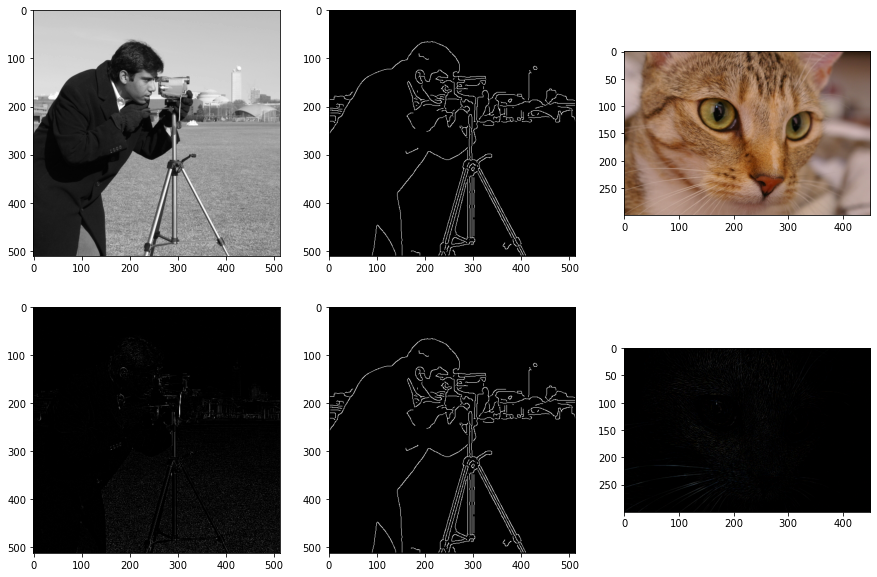

In [26]:
#Top Hat (imagen - apertura)

def img_top_hat(img, se):
    img_top_hat = img - img_opening(img, se)
    return img_top_hat

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_top_hat(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_top_hat(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_top_hat(img_rgb, se_circle))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


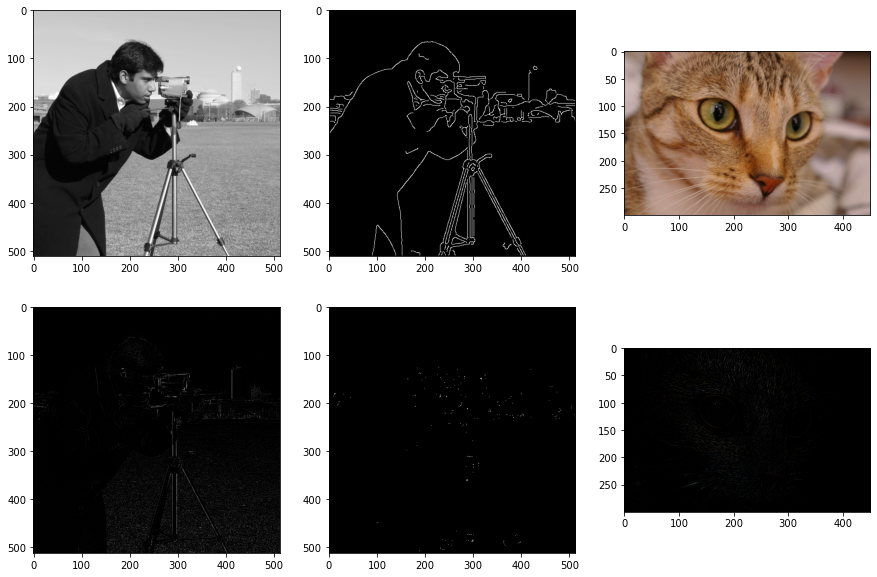

In [28]:
#Botton-Hat (img - cierre)

def img_bot_hat(img, se):
    img_bot_hat = img_closing(img, se) - img
    return img_bot_hat

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_bot_hat(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_bot_hat(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_bot_hat(img_rgb, se_circle))


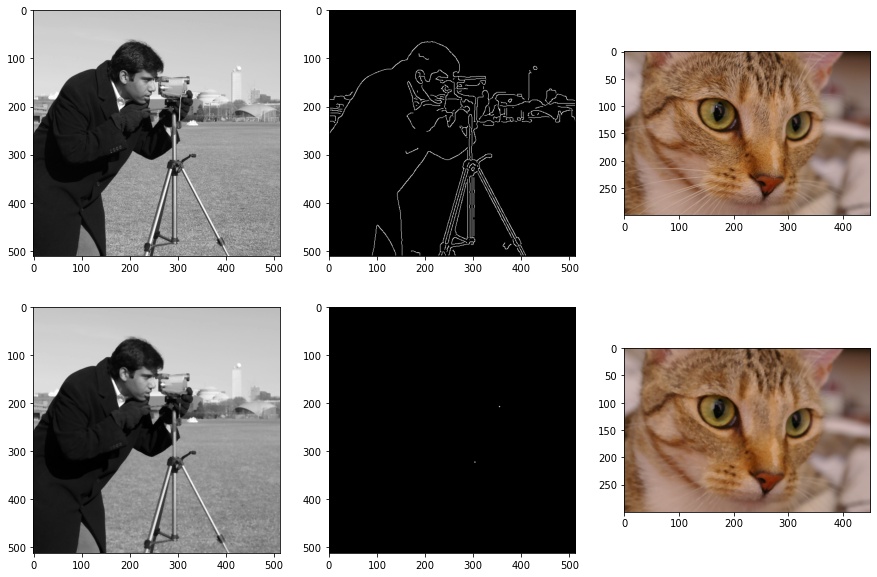

In [29]:
#OC
def img_OC(img, se):
    img_OC = img_closing(img_opening(img, se), se)
    return img_OC

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_OC(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_OC(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_OC(img_rgb, se_circle))

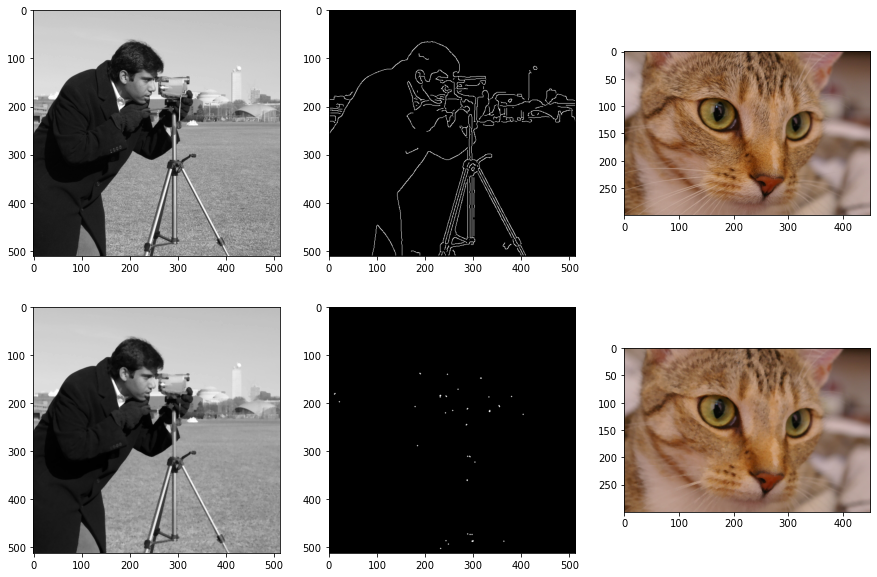

In [30]:
#CO
def img_CO(img, se):
    img_CO = img_opening(img_closing(img, se), se)
    return img_CO

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,1].imshow(img_bin, 'gray')
axes[0,2].imshow(img_rgb)
axes[1,0].imshow(img_CO(img_gray, se_circle) , 'gray')
axes[1,1].imshow(img_CO(img_bin, se_circle), 'gray')
axes[1,2].imshow(img_CO(img_rgb, se_circle))